# NLP Project: Real vs. Fake News 

This project will attempt to classify news headlines as real or fake using Natural Language Processing methods.

In [29]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import nltk

### Loading the data

In [ ]:
# the datasets contain no headers, and are not comma separated
training_data = pd.read_csv("dataset/training_data.csv", sep="\t", names=["class", "headline"])
testing_data = pd.read_csv("dataset/testing_data.csv", sep="\t", names=["class", "headline"])

display(training_data.head())
display(testing_data.head())

,class,headline
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


,class,headline
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


In [ ]:
# check training data 
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     34152 non-null  int64 
 1   headline  34152 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.8+ KB


The training data has no null values to handle.

In [25]:
training_data["class"].value_counts()

class
0    17572
1    16580
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

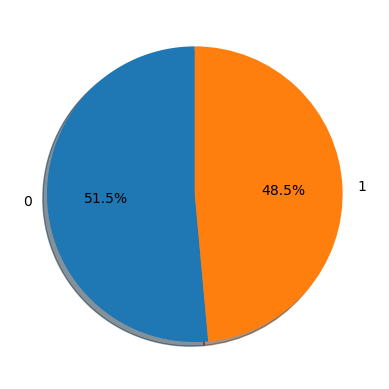

In [24]:
plt.pie(data=training_data, x=training_data["class"].value_counts(), autopct='%1.1f%%',
        shadow=True, startangle=90, labels=["0", "1"])
plt.show

There are slightly more headlines tagged with 0 than 1, with 51.5% of the headlines as 0.

### Before we start modifying the datasets, let's make copies

In [26]:
df_train = training_data.copy()
df_test = testing_data.copy()

### Let's do some general text preprocessing before splitting the training data

In [27]:
# 1. remove punctuation
df_train["headline"].replace("[^a-zA-Z]", " ", regex=True, inplace=True)
df_train.head()

,class,headline
0,0,donald trump sends out embarrassing new year s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama s name ...
4,0,pope francis just called out donald trump duri...


In [28]:
# 2. lowercase everything (though a glance at data suggests it is already done)
df_train["headline"].str.lower()
df_train.head()

,class,headline
0,0,donald trump sends out embarrassing new year s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama s name ...
4,0,pope francis just called out donald trump duri...


In [30]:
from nltk.corpus import stopwords
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /Users/laura/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
# 3. remove stop words

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    return " ".join(
        w for w in text.lower().split()
        if w not in stop_words
    )

df_train["headline"] = df_train["headline"].apply(remove_stop_words)

df_train.head()

,class,headline
0,0,donald trump sends embarrassing new year eve m...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes internet joke thr...
3,0,trump obsessed even obama name coded website i...
4,0,pope francis called donald trump christmas speech


### Splitting the dataset

In [32]:
from sklearn.model_selection import train_test_split

labels = df_train["class"]

X_train, X_test, y_train, y_test = train_test_split(df_train["headline"], df_train["class"], test_size=0.2, random_state=42)

### Lemmatisation

In [43]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def lemmatize(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc if token.is_alpha)

X_train = X_train.apply(lemmatize)

In [44]:
X_train

8891                                                      
25115    final reckoning approach obama high court nominee
26933    illinois budget talk fizzle amid partisan entr...
26971    clinton spokesman ig report show clinton misst...
11387    bust nancy pelosi claim meet russian ambassado...
                               ...                        
16850                          senate pass usa freedom act
6265     oklahoma republicans try impeach obama dumb re...
11284    texas congressman let scream leftist agitator sir
860      trump stole idea north korean propaganda parod...
15795    outrageous nancy pelosi claim obamacare honor ...
Name: headline, Length: 27321, dtype: object

In [45]:
X_test

18499              release house tax bill delayed thursday
24785           confusion trump first talks foreign leader
27282    obama says chinese led trade deal shows need t...
6151            former pastor turned teacher beat students
16785    breaking south carolina senate caves votes rem...
                               ...                        
24525    trump creates business advisory council stacke...
12892    tomi lahren takes hammer hillary competent wom...
12365    hope forgotten america trump last chance steel...
13642    breaking fbi investigating clinton crony virgi...
24425    u mayors ask trump keep young illegal immigrat...
Name: headline, Length: 6831, dtype: object

In [46]:
# also lemmatize the test data

X_test = X_test.apply(lemmatize)
X_test

18499                release house tax bill delay thursday
24785            confusion trump first talk foreign leader
27282    obama say chinese lead trade deal show need tp...
6151               former pastor turn teacher beat student
16785    break south carolina senate cave vote remove c...
                               ...                        
24525     trump create business advisory council stack ceo
12892    tomi lahren take hammer hillary competent woma...
12365    hope forgotten america trump last chance steel...
13642    break fbi investigate clinton crony virginia g...
24425    u mayor ask trump keep young illegal immigrati...
Name: headline, Length: 6831, dtype: object

## Models

### Random Forest Classifier

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(X_train)    # use training data to fit the vectoriser and then transform the data
tfidf_test_matrix = vectorizer.transform(X_test)    # use the fit vectoriser to transform testing data

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

rf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("rfc", RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=42))
])

rf_param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__min_df": [1,2,5],
    "tfidf__max_df": [0.85, 0.9, 0.95],
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, scoring="accuracy", cv=5, verbose=2)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=  10.4s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=  10.5s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=  10.7s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=  10.7s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=  10.7s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=  33.1s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=  32.7s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=  33.0s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=  33.4s
[CV] END tfidf__max_df=0.85, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=  32.8s
[CV] END tfidf__ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(criterion='entropy',
                                                               n_estimators=200,
                                                               random_state=42))]),
             param_grid={'tfidf__max_df': [0.85, 0.9, 0.95],
                         'tfidf__min_df': [1, 2, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=2)

In [50]:
rf_best_model = rf_grid.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)

In [51]:
rf_matrix = confusion_matrix(y_test, rf_y_pred)
print(rf_matrix)

[[3224  305]
 [ 233 3069]]


In [52]:
rf_acc = accuracy_score(y_test, rf_y_pred)
print(rf_acc)

0.921241399502269


In [53]:
rf_report = classification_report(y_test, rf_y_pred)
print(rf_report)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3529
           1       0.91      0.93      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831



### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1, 3))),
    ("lr", LogisticRegression(random_state=42, max_iter=500))
])

lr_params = {
    "lr__C": [0.1, 1, 10],
}

lr_grid = GridSearchCV(lr_pipeline, lr_params, scoring="accuracy", cv=5, verbose=2)
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..........................................lr__C=0.1; total time=   0.5s
[CV] END ..........................................lr__C=0.1; total time=   0.4s
[CV] END ..........................................lr__C=0.1; total time=   0.4s
[CV] END ..........................................lr__C=0.1; total time=   0.4s
[CV] END ..........................................lr__C=0.1; total time=   0.4s
[CV] END ............................................lr__C=1; total time=   0.5s
[CV] END ............................................lr__C=1; total time=   0.4s
[CV] END ............................................lr__C=1; total time=   0.5s
[CV] END ............................................lr__C=1; total time=   0.4s
[CV] END ............................................lr__C=1; total time=   0.5s
[CV] END ...........................................lr__C=10; total time=   0.4s
[CV] END ........................................

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.85, min_df=2,
                                                        ngram_range=(1, 3))),
                                       ('lr',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             param_grid={'lr__C': [0.1, 1, 10]}, scoring='accuracy', verbose=2)

In [57]:
lr_best_model = lr_grid.best_estimator_
lr_y_pred = lr_best_model.predict(X_test)

In [58]:
lr_matrix = confusion_matrix(y_test, lr_y_pred)
print(lr_matrix)

[[3311  218]
 [ 183 3119]]


In [59]:
lr_acc = accuracy_score(y_test, lr_y_pred)
print(lr_acc)

0.94129702825355


In [60]:
lr_report = classification_report(y_test, lr_y_pred)
print(lr_report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3529
           1       0.93      0.94      0.94      3302

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



### LinearSVC

In [66]:
from sklearn.svm import LinearSVC

lsvc_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1, 3))),
    ("lsvc", LinearSVC(random_state=42, class_weight="balanced"))
])

lsvc_grid_params = {
    "lsvc__C": [0.01, 0.1, 1, 10]
}

lsvc_grid = GridSearchCV(lsvc_pipeline, lsvc_grid_params, scoring="accuracy", cv=5, verbose=2)
lsvc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................................lsvc__C=0.01; total time=   0.4s
[CV] END .......................................lsvc__C=0.01; total time=   0.3s
[CV] END .......................................lsvc__C=0.01; total time=   0.3s
[CV] END .......................................lsvc__C=0.01; total time=   0.3s
[CV] END .......................................lsvc__C=0.01; total time=   0.3s
[CV] END ........................................lsvc__C=0.1; total time=   0.3s
[CV] END ........................................lsvc__C=0.1; total time=   0.3s
[CV] END ........................................lsvc__C=0.1; total time=   0.4s
[CV] END ........................................lsvc__C=0.1; total time=   0.3s
[CV] END ........................................lsvc__C=0.1; total time=   0.3s
[CV] END ..........................................lsvc__C=1; total time=   0.3s
[CV] END ........................................

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.85, min_df=2,
                                                        ngram_range=(1, 3))),
                                       ('lsvc',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=42))]),
             param_grid={'lsvc__C': [0.01, 0.1, 1, 10]}, scoring='accuracy',
             verbose=2)

In [67]:
lsvc_best_model = lsvc_grid.best_estimator_
lsvc_y_pred = lsvc_best_model.predict(X_test)

In [68]:
lsvc_matrix = confusion_matrix(y_test, lsvc_y_pred)
print(lsvc_matrix)

[[3308  221]
 [ 177 3125]]


In [69]:
lsvc_acc = accuracy_score(y_test, lsvc_y_pred)
print(lsvc_acc)

0.9417362026057678


In [70]:
lsvc_report = classification_report(y_test, lsvc_y_pred)
print(lsvc_report)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3529
           1       0.93      0.95      0.94      3302

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



## Final testing

We'll take the testing data through the same preprocessing steps as we did for the training dataset

In [75]:
# 1. remove punctuation
df_test["headline"].replace("[^a-zA-Z]", " ", regex=True, inplace=True)
df_test.head()

,class,headline
0,2,copycat muslim terrorist arrested with assault...
1,2,wow chicago protester caught on camera admits...
2,2,germany s fdp look to fill schaeuble s big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u n seeks massive aid boost amid rohingya ...


In [ ]:
# 2. lowercase
df_test["headline"].str.lower()
df_test.head()

,class,headline
0,2,copycat muslim terrorist arrested with assault...
1,2,wow chicago protester caught on camera admits...
2,2,germany s fdp look to fill schaeuble s big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u n seeks massive aid boost amid rohingya ...


In [76]:
# 3. remove stopwords
df_test["headline"] = df_test["headline"].apply(remove_stop_words)
df_test.head()

,class,headline
0,2,copycat muslim terrorist arrested assault weapons
1,2,wow chicago protester caught camera admits vio...
2,2,germany fdp look fill schaeuble big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u n seeks massive aid boost amid rohingya emer...


In [77]:
# 4. lemmatisation
df_test["headline"] = df_test["headline"].apply(lemmatize)
df_test.head()

,class,headline
0,2,copycat muslim terrorist arrest assault weapon
1,2,wow chicago protester catch camera admit viole...
2,2,germany fdp look fill schaeuble big shoe
3,2,mi school send welcome back packet warning kid...
4,2,u n seek massive aid boost amid rohingya emerg...


### Predict the labels with LinearSVC

In [ ]:
# make predictions
testing_pred = lsvc_best_model.predict(df_test["headline"])

In [ ]:
# get the clean data to be used for writing back the predictions with the unprocessed headlines
test_pred_df = testing_data.copy()

In [84]:
# overwrite the classes in the dataframe
test_pred_df["class"] = testing_pred

In [85]:
test_pred_df.head()

,class,headline
0,0,copycat muslim terrorist arrested with assault...
1,0,wow! chicago protester caught on camera admits...
2,1,germany's fdp look to fill schaeuble's big shoes
3,0,mi school sends welcome back packet warning ki...
4,1,u.n. seeks 'massive' aid boost amid rohingya '...


In [87]:
# overwrite existing dataset
test_pred_df.to_csv("dataset/testing_data.csv", header=False, sep="\t", index=False )

In [88]:
test_pred_df["class"].value_counts()

class
1    5138
0    4846
Name: count, dtype: int64

In [89]:
test_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9984 entries, 0 to 9983
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     9984 non-null   int64 
 1   headline  9984 non-null   object
dtypes: int64(1), object(1)
memory usage: 156.1+ KB


<function matplotlib.pyplot.show(close=None, block=None)>

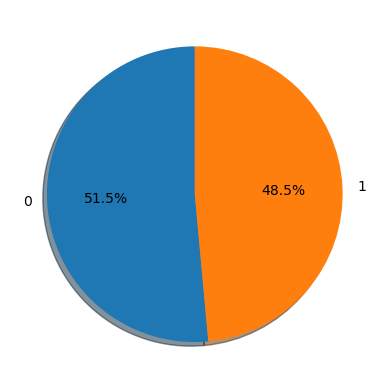

In [90]:
plt.pie(data=test_pred_df, x=test_pred_df["class"].value_counts(), autopct='%1.1f%%',
        shadow=True, startangle=90, labels=["0", "1"])
plt.show